# Тема курсовой работы: идентификация личности по голосу

### git репозиторий работы: https://github.com/qdzzzxc/voice_classification_dusha

# Цель работы

- Построение системы, используемой для проверки принадлежности голоса исходной базе голосов, а также идентификации личности говорящего

# Задачи

- Получение датасета голосовых сообщений
    - преобразование данных в удобный для работы формат

- Преобразование аудиодорожки в вектор данных
    - изучение алгоритма получения мел-кепстральных коэффициентов (MFCC)
    - изучение возможностей библиотеки librosa для обработки аудио
    - применение данных методов к собранным данным

- Построение модели машинного обучения
    - определение лучшей архитектуры модели
    - определение необходимого количества аудио файлов для идентификации личности человека
    - качественное сравнение признаков из различных алгоритмов векторизации аудио
    - выбор наилучшей модели

- Решение задачи проверки на принадлежность личности к датасету голосов
    - анализ распределения вероятностей при принадлежности к тренировочным данным/новым для модели данным
    - изучение и применение tpr@fpr метрики

- Применение модели на реальном примере
    - создание пайплайна использования предсказания модели для проверки голоса на принадлежность обучающей выборке
    - создание графического web интерфейса с помощью библиотеки gradio

### Сбор данных

В своей работе я использовал открытый датасет dusha, содержащий множество голосовых сообщений от разных людей (ссылка на датасет: https://developers.sber.ru/portal/products/dusha).
<br>
После удаления дубликатов по тексту голосового сообщения, используемая мной часть датасета (crowd_train) содержала в себе 124 569 записей. Удалённые строки при повторной проверке и правда оказались дубликатами других аудио.

Строки, полученные после удаления дубликатов, содержат в себе сообщения от 1806 различных пользователей. Очевидно, что данное количество слишком велико. Кроме того, количество аудиозаписей от разных пользователей колеблется от 1 до 500 на одного человека. Чтобы избежать проблемы дисбаланса классов, я использую функцию, ограничивающее количество человек в выборке и берущее для всех классов одинаковое количество сообщений (обычно это 5, но для сравнения ниже рассмотрены случаи с 10 аудио на человека)

Датасет очень большой, поэтому пути до аудио файлов хранятся в json формате. Считываю их и преобразую в pandas dataframe.

Импорт всех библиотек, использующихся в работе

In [ ]:
import IPython.display as ipd
from copy import copy
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import scipy.fftpack as fft
from scipy.io import wavfile
from scipy.signal import get_window
from scipy.spatial.distance import cosine

from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import catboost

import librosa
import mlflow
import gradio as gr


from my_funcs import get_dataframe, get_model_and_params, get_feature

from tqdm.notebook import tqdm

tqdm.pandas()

In [ ]:
with open(
    "Z:/python_project/course_work_stepanov/crowd_train/raw_crowd_train.jsonl", "r"
) as file:


    lines = file.read().splitlines()

In [ ]:
dicts = [eval(x.replace("NaN", "np.nan")) for x in lines]

In [ ]:
df = pd.DataFrame.from_records(dicts)
df.shape

(906953, 9)

Удалив дубликаты по тексту в сообщении, датасет уменьшился в 7 раз...

In [ ]:
df_not_dupl = df.drop_duplicates(subset="speaker_text")
df_not_dupl.shape

(124569, 9)

In [ ]:
df_not_dupl.to_parquet("crowd_train_without_duplicates.pqt")

In [ ]:
res = df_not_dupl.source_id.value_counts()

Как видно, количество сообщений от пользователей сильно разнится. Для того, чтобы не столкнуться с дисбалансом классов, я буду использовать функцию get_dataframe из файла my_funcs.py

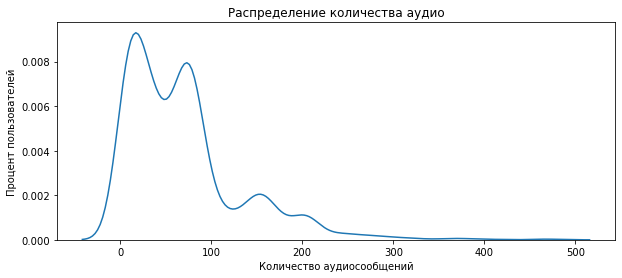

In [ ]:
plt.figure(figsize=(10, 4))
plt.title("Распределение количества аудио")
sns.kdeplot(res.values)
plt.ylabel("Процент пользователей")
plt.xlabel("Количество аудиосообщений")
plt.show()

Удаляю ненужные мне столбцы и сохраняю датафрейм

In [ ]:
df_final = df_not_dupl.drop(
    columns=[
        'hash_id',
        'annotator_emo',
        'golden_emo',
        'annotator_id',
        'speaker_text',
        'speaker_emo',
    ]
).dropna()


df_final = df_final[df_final.source_id.isin(res.index)]


df_final.shape

(124449, 3)

In [ ]:
df_final.to_parquet("crowd_train_eda.pqt", index=False)

## Извлечение признаков

Для извлечения признаков я использую такие алгоритмы как построение хромограммы, мел-спектрограммы, получение мел-кепстральных коэффициентов, тональных центров тяжести. 

Рассмотрю подробно алгоритм для получения мел-кепстральных коэффициентов, которые по итогу оказались наиболее значимыми признаками, а следовательно и лучшей характеристикой аудиосигнала

### Аудио, на котором будет производиться разбор алгоритма по получению мел-кепстральных коэффициентов (MFCCs)

In [ ]:
audio_file = "test.wav"
ipd.Audio(audio_file)


### Выведу его показатели, такие как длительность и частота дискретизации (количество выборок данных из непрерывного сигнала, отвечает за качество итогового представления аудио)

In [ ]:
sample_rate, audio = wavfile.read(audio_file)
print("Частота дискретизации: {0}Hz".format(sample_rate))
print("Длительность: {0}s".format(len(audio) / sample_rate))
if len(audio.shape) > 1:
    audio = audio[:, 0]
    print("Удалены все аудио каналы, кроме первого")

Частота дискретизации: 44100Hz
Длительность: 7.512018140589569s
Удалены все аудио каналы, кроме первого


Так как амплитудные значения аудиосигнала могут принимать любые значения, необходимо провести их нормировку для адекватного сравнения аудиодорожек между собой.

На графике ниже представлена спектрограмма нормированного сигнала анализируемого аудиофайла

In [ ]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio


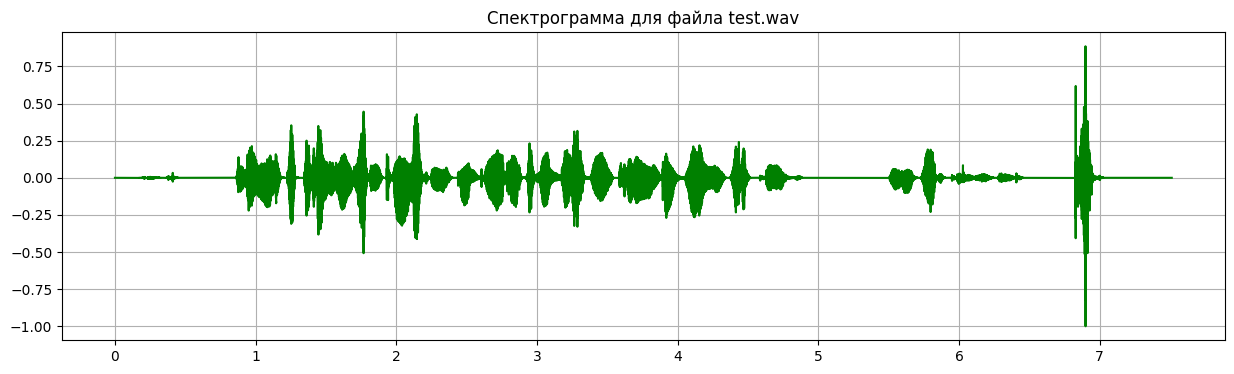

In [ ]:
audio = normalize_audio(audio)
plt.figure(figsize=(15, 4))
plt.title(f"Спектрограмма для файла {audio_file}")
plt.plot(np.linspace(0, len(audio) / sample_rate,
         num=len(audio)), audio, color="green")
plt.grid(True)

Так как преобразование Фурье создаёт искажения для нестационарных рядов данных, необходимо сделать аудиоряд стационарным. Поэтому я разделю его на мелкие окна, каждое из которых настолько мало, что оно не может быть нестационарным.

In [ ]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    audio = np.pad(
        audio, int(FFT_size / 2), mode="reflect"
    )  # паддинг для прохождения окном
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))

    for n in range(frame_num):
        frames[n] = audio[n * frame_len: n * frame_len + FFT_size]

    return frames

In [ ]:
hop_size = 25  # длина фрейма в миллисекундах
FFT_size = 2048

audio_framed = frame_audio(
    audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate
)
print(
    f"Итоговое количество окон: {audio_framed.shape[0]}, Длина каждого окна: {audio_framed.shape[1]}"
)


Итоговое количество окон: 301, Длина каждого окна: 2048


Визуализирую полученные аудиосигналы

In [ ]:
def plot_audio(audio):
    plt.figure(figsize=(15, 4))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)

    plt.grid()


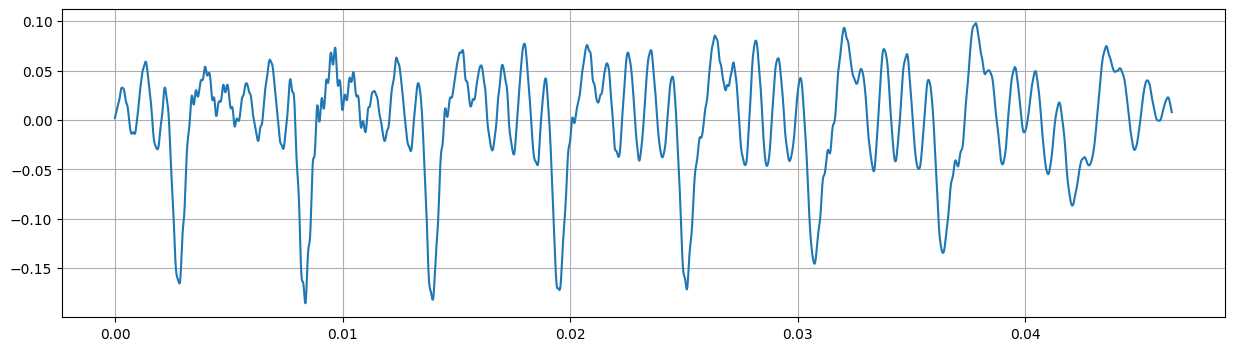

In [ ]:
plot_audio(audio_framed[100])

Видно, что каждое окно является внутренней вырезкой из исходного аудиосигнала. Для уменьшения краевых эффектов во время применения дискретного преобразования Фурье, которое будет описано дальше, а также для фокусировке на локальном содержании фрейма (ведь фреймы, построенные выше, пересекаются, а также дополнены паддингом, то есть каждый кусочек сигнала в какой-то момент времени будет центральным в фрейме) используются окна, призванные сгладить аудиоряд на концах записи

Наиболее часто используемые виды окон это окно Ханнинга и окно Кайзера (которое при использовании параметра beta = 4 идентично окну Ханнинга)

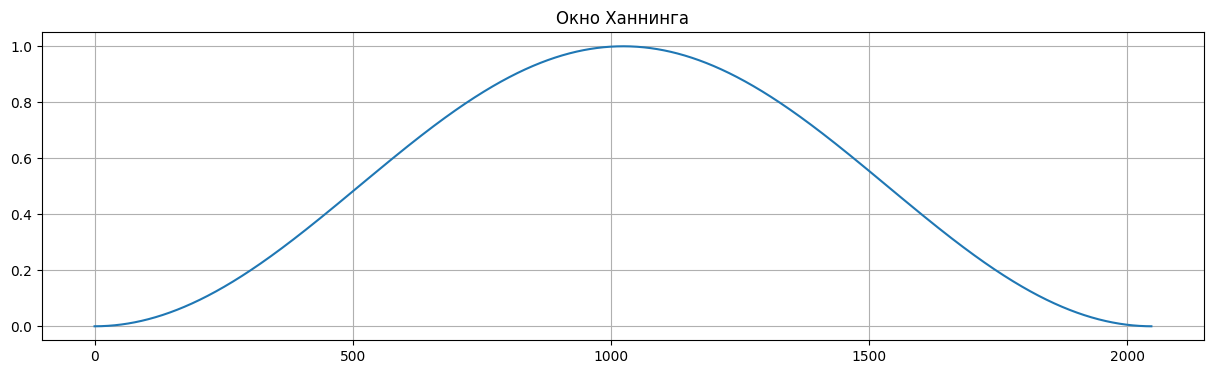

In [ ]:
hann_window = get_window("hann", FFT_size)
plt.figure(figsize=(15, 4))
plt.title("Окно Ханнинга")
plt.plot(hann_window)
plt.grid()


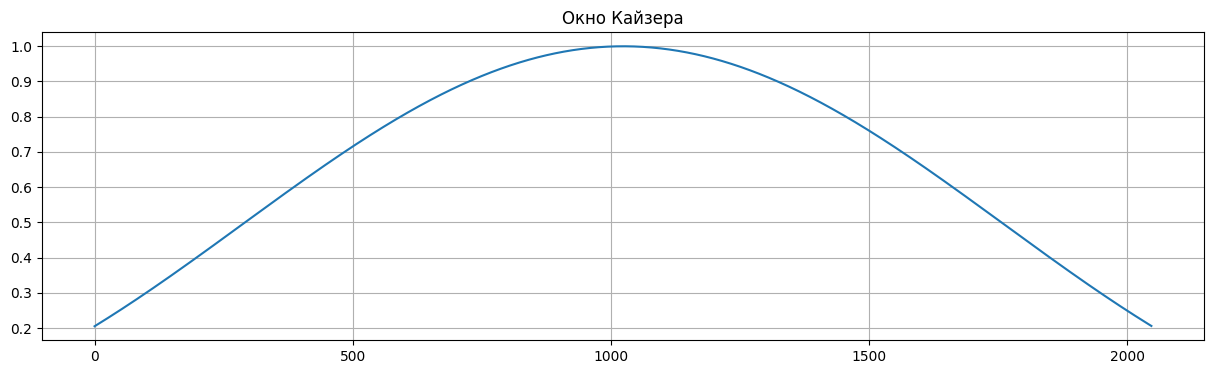

In [ ]:
kaiser_window = get_window(("kaiser", 3), FFT_size)
plt.figure(figsize=(15, 4))
plt.title("Окно Кайзера")
plt.plot(kaiser_window)
plt.grid()


Окна можно применять последовательно. Выберу окно Ханнинга, так как при его использовании нет необходимости подбирать гиперпараметр beta

Визуализирую сигнал до и после применения окна

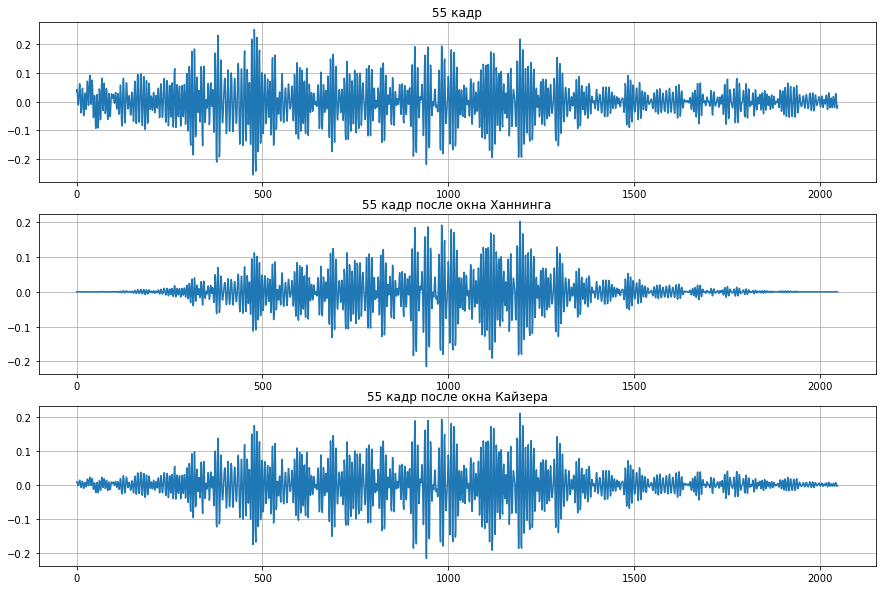

In [ ]:
audio_hann = audio_framed * hann_window
audio_kaiser = audio_framed * kaiser_window

ind = 55
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(audio_framed[ind])
plt.title(f"{ind} кадр")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(audio_hann[ind])
plt.title(f"{ind} кадр после окна Ханнинга")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(audio_kaiser[ind])
plt.title(f"{ind} кадр после окна Кайзера")
plt.grid()

### С помощью быстрого преобразования Фурье обработаю полученные фреймы. Длина окна в этом алгоритме делится пополам, так как спектр симметричен и отрицательные значения сигнала не несут никакой информации

In [ ]:
audio_winT = np.transpose(audio_hann)

audio_fft = np.empty(
    (int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order="F"
)
for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[: audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)


Мощность сигнала (необходима для перевода в децибелы) можно найти по формуле ниже. В данном контексте мощность это то, как много энергии содержится в каждой частотной компоненте того или иного сигнала

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(301, 1025)


Для построения мел-кепстральных коэффициентов необходимо также перейти от частотной шкалы к мел шкале. Мел шкала - это шкала восприятия звуков, построенная на статистической обработке большого количества данных. Мел шкала построена так, что звуки, оценённые по ней, располагаются на одинаковом расстоянии друг от друга. В формуле для вычисления мел используется только частота, хотя доказано, что восприятие звука также зависит от уровня его громкости и тембра, которые опущены в данной формуле.

Сама формула очень проста и выглядит следующим образом:
<br>
$Mel(freq) = 2595 \cdot log(1 + \frac{freq}{700})$
<br>
$Freq(mel) = 700 \cdot (10^{\frac{mel}{2595}} - 1)$

In [ ]:
def freq2mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)


def mel2freq(mels):
    return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)


Необходимо получить треугольные фильтры, которые равномерно распределены по мел шкале. Для этого просто разобью мел шкалу на равные участки. Данные фильтры в частотной шкале смещены к более низким частотам

In [ ]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq2mel(fmin)
    fmax_mel = freq2mel(fmax)

    print(f"Минимальный MEL: {fmin_mel}")
    print(f"Максимальный MEL: {fmax_mel}")

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num + 2)
    freqs = mel2freq(mels)

    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs


In [ ]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print(f"Минимальная частота: {freq_min}")
print(f"Максимальная частота: {freq_high}")

filter_points, mel_freqs = get_filter_points(
    freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate
)
filter_points.shape, mel_freqs.shape


Минимальная частота: 0
Максимальная частота: 22050.0
Минимальный MEL: 0.0
Максимальный MEL: 3923.337321740179


((12,), (12,))

По полученным точкам создаю фильтры в виде треугольников, которые имеют возрастающую и убывающую части

In [ ]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros(
        (len(filter_points) - 2, int(FFT_size / 2 + 1))
    )  # половина fft достаточна из-за отсутствия информации в отрицательной части спектра

    for n in range(len(filter_points) - 2):
        filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(
            0, 1, filter_points[n + 1] - filter_points[n]
        )  # возрастающая часть
        filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(
            1, 0, filter_points[n + 2] - filter_points[n + 1]
        )  # убывающая часть
    return filters

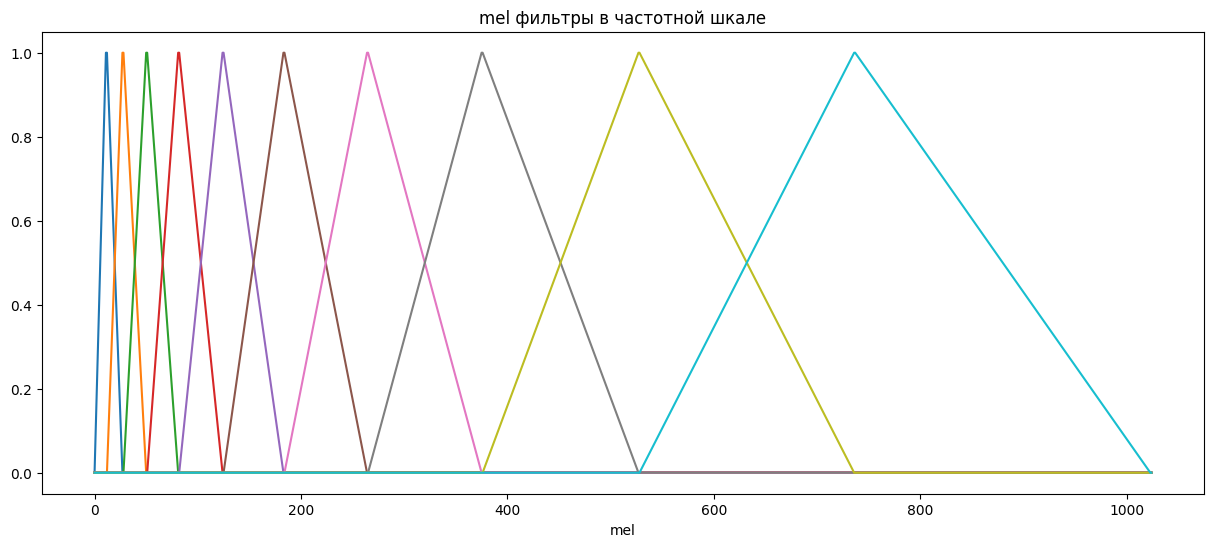

In [ ]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15, 6))

for n in range(filters.shape[0]):
    plt.title("mel фильтры в частотной шкале")
    plt.plot(filters[n])
    plt.xlabel("mel")


### Нормализация фильтров может помочь с тем, что количество шума увеличивается с увеличением частоты, ведь на более высокой частоте фильтры растянуты и захватывают больший диапазон частот

In [ ]:
enorm = 2 / (
    mel_freqs[2: mel_filter_num + 2] - mel_freqs[:mel_filter_num]
)  # делю на ширину фильтра
filters *= enorm[:, np.newaxis]

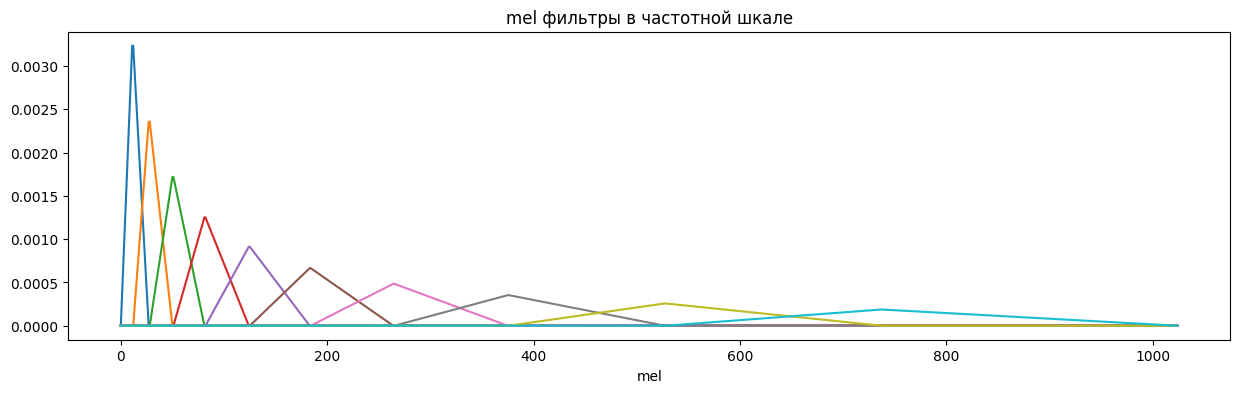

In [ ]:
plt.figure(figsize=(15, 4))
for n in range(filters.shape[0]):
    plt.title("mel фильтры в частотной шкале")
    plt.plot(filters[n])
    plt.xlabel("mel")


Необходимо произвести перевод мощности сигнала в децибелы (нужны для получения кепстральных коэффициентов), характеризующих уровень затухания сигнала. Они обычно используются в сферах, где работа происходит с большим диапазоном частот (что можно сказать и о моём анализе) 

Перевод осуществляется по простой формуле:
<br>
$ D_p = 10 \cdot lg\frac{P_2}{P_1} $

In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
# warning возникает при отсутствии сигнала
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

C:\Users\Никита\AppData\Local\Temp\ipykernel_9640\1110158089.py:2: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered) #warning возникает при отсутствии сигнала


(10, 301)

Последним шагом для получения мел-кепстральных коэффициентов является применение дискретного преобразования Фурье. Можно использовать любой тип (1, 2, 3 или 4), я использую второй как наиболее часто используемый вариант

Формула для данного преобразования выглядит следующим образом:
<br>
$y_k = 2 \sum_{n=0}^{N-1} x_n cos(\frac{\pi k (2n + 1)}{2 N})$

In [ ]:
n_mfccs = 20

cepstral_coefficents = fft.dct(audio_log.T, n=n_mfccs, type=2).T
cepstral_coefficents = np.nan_to_num(
    cepstral_coefficents, nan=0.0, posinf=None, neginf=0
)  # убираю None и -inf значения, возникающие из-за отсутствия сигнала
cepstral_coefficents.shape


(20, 301)

## Полученный результат

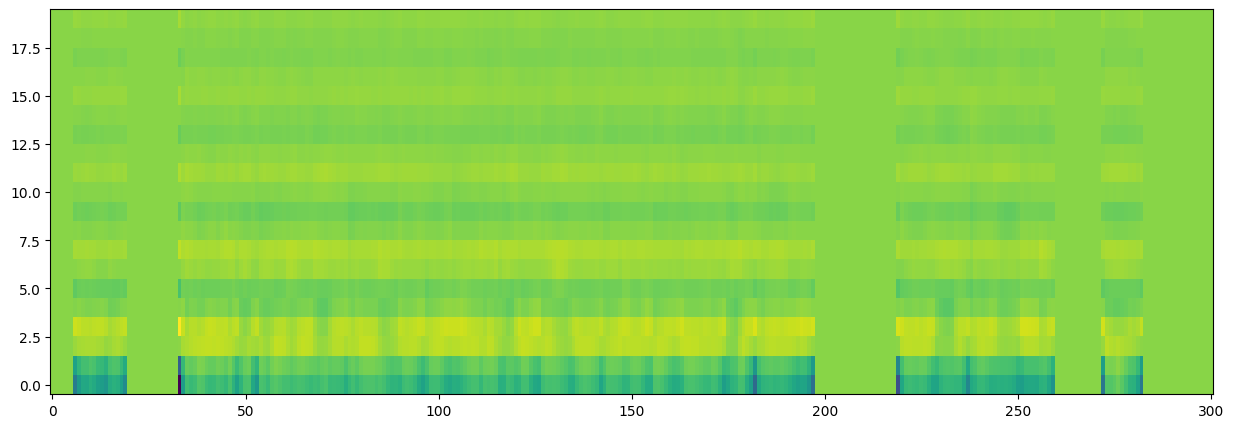

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(cepstral_coefficents, aspect="auto", origin="lower")
plt.show()

## Реализация библиотеки librosa

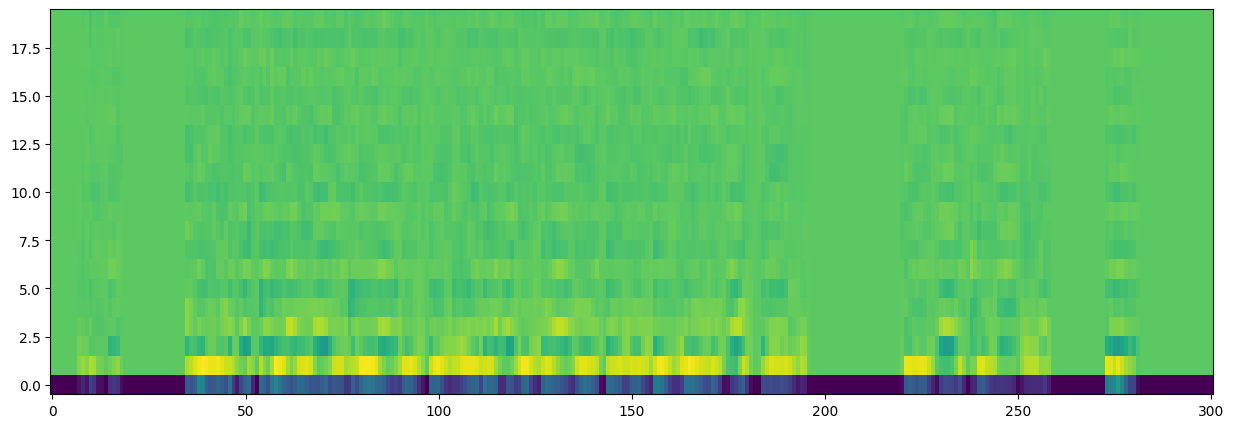

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(
    librosa.feature.mfcc(
        y=audio,
        n_mfcc=20,
        sr=sample_rate,
        dct_type=2,
        n_fft=1024,
        hop_length=round(sample_rate * 25 / 1_000),
    ),
    aspect="auto",
    origin="lower",
)
plt.show()

## Подготовка данных для модели машинного обучения

Как видно, полученные мел-кепстральные коэффициенты представляют собой матрицу размерности 20 (подбираемый гиперпараметр, оптимальное значение от 15 до 20) на число, зависящее от длительности аудиозаписи. Большинство моделей принимают на вход данные в векторном, а не в матричном представлении. Возможное решение это растяжение полученной матрицы в вектор с помощью операции flatten, но это создаёт очень большое количество незначимых признаков. Кроме того, для приведения всех данных к одной длине по второму измерению необходимо производить truncate или padding над признаками, что также создаёт много нулевых признаков или обрезает возможно значимые значения.

### Для решения этой проблемы я следующий подход:
<br>
В качестве признаков для своей модели я использую такие показатели как минимум, максимум и среднее по первой размерности, что позволяет получить 60 признаков (3 значения для каждого из 20 каналов), которые, как будет показано далее, позволяют хорошо классифицировать аудиосигналы

In [ ]:
cepstral_coefficents.shape

(20, 301)

In [ ]:
mfcc_mean = cepstral_coefficents.mean(axis=1)
mfcc_min = cepstral_coefficents.min(axis=1)
mfcc_max = cepstral_coefficents.max(axis=1)
mfcc_features = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))
mfcc_features.shape

(60,)

Как было сказано выше, я использовал также такие методы получения признаков из аудиоданных, как хромограмма, мел-спектрограмма, тональные центры тяжести. Применял все эти методы к моим данным и сохранял их в датафрейм с помощью следующего кода:

In [ ]:
def mfccs_from_file(file_path, maxlen=None):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')

        if len(audio) == 0:
            raise ValueError(f"Input signal length is too small in file: {file_path}")

        if sr != 22050:
            audio = librosa.resample(audio, sr, 22050, res_type='kaiser_fast')

        mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=20)

        maxlen = maxlen if maxlen else 256
        if mfccs.shape[1] > maxlen:
            mfccs = mfccs[:, :maxlen]
        elif mfccs.shape[1] < maxlen:
            mfccs = np.pad(
                mfccs, ((0, 0), (0, maxlen - mfccs.shape[1])), mode='constant'
            )

        return mfccs
    except Exception as e:
        print(e)

In [ ]:
def get_mfcc(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=0, duration=30)
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    return mfcc


def get_melspectrogram(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=0, duration=30)
    melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    return melspectrogram


def get_chroma_vector(wav_file_path):
    y, sr = librosa.load(wav_file_path)
    chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    return chroma


def get_tonnetz(wav_file_path):
    y, sr = librosa.load(wav_file_path)
    tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
    return tonnetz


def get_feature(file_path):
    mfcc = get_mfcc(file_path)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    melspectrogram = get_melspectrogram(file_path)
    melspectrogram_mean = melspectrogram.mean(axis=1)
    melspectrogram_min = melspectrogram.min(axis=1)
    melspectrogram_max = melspectrogram.max(axis=1)
    melspectrogram_feature = np.concatenate(
        (melspectrogram_mean, melspectrogram_min, melspectrogram_max)
    )

    chroma = get_chroma_vector(file_path)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    tntz = get_tonnetz(file_path)
    tntz_mean = tntz.mean(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate((tntz_mean, tntz_min, tntz_max))

    feature = np.concatenate(
        (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature)
    )
    return feature

In [ ]:
df = pd.read_parquet("crowd_train_without_duplicates.pqt")

In [ ]:
df.source_id.nunique()

1806

In [ ]:
tqdm.pandas()

df.audio_path = df["audio_path"].progress_apply(
    lambda x: os.path.join("crowd_train", x)
)

  0%|          | 0/124569 [00:00<?, ?it/s]

In [ ]:
df["audio_feature"] = df["audio_path"].progress_apply(lambda x: get_feature(x))

In [ ]:
df.to_pickle(
    "crowd_train_all_data_embedded.pkl"
)  # в pickle, чтобы np.array не стали строками

# Построение модели

Первоначальная идея состояла в разделении выборки на кластеры на основе признаков из аудиосообщений. На практике, все алгоритмы кластеризации требуют большое количество данных в каждом кластере, что не подходит под бизнес задачу работы, ведь ни один человек не согласиться записывать по 350 голосовых сообщений для добавления его голоса в базу данных. 

В основном, я использовал небольшую подвыборку из датасета, призванную симулировать реальные условия применения данной модели. Я решил действовать в рамках пяти голосовых сообщений на одного пользователя. Также пробовал по 350 объектов на один класс с малым количеством классов исключительно для задачи кластеризации, что всё равно не смогло обеспечить достойного результата.

Конечным подходом, позволившим получить наилучший результат, стало построение модели-классификатора.

Все модели я логировал с помощью mlflow, что сильно облегчило сравнение различных моделей во время экспериментов.

>  ***Код всех экспериментов с моделями находится в папке experiments***

Итоговое качество моделей также проверялось с помощью кросс-валидации. Код проверки можно найти в файле

>  ***cross_validation_scores\best_models_cross_validation.ipynb***

### Рассмотрю все построенные модели и выберу наилучшие из них

## Первый подход: обучение без учителя, кластеризация голосов

## Модели с заранее известным количеством кластеров, 102 класса, 5 аудиозаписей на каждый класс

In [3]:
experiment_name = "clusterization, 102 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    "experiment_id"]
clust_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=["metrics.f1_weighted"])
clust_102_5_df = clust_102_5_df.iloc[::-1][
    [
        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
    ]
]
clust_102_5_df = pd.melt(
    clust_102_5_df,
    id_vars="tags.mlflow.runName",
    value_vars=["metrics.f1_weighted", "metrics.f1_micro", "metrics.accuracy"],
    var_name="Metric",
    value_name="Value",
)

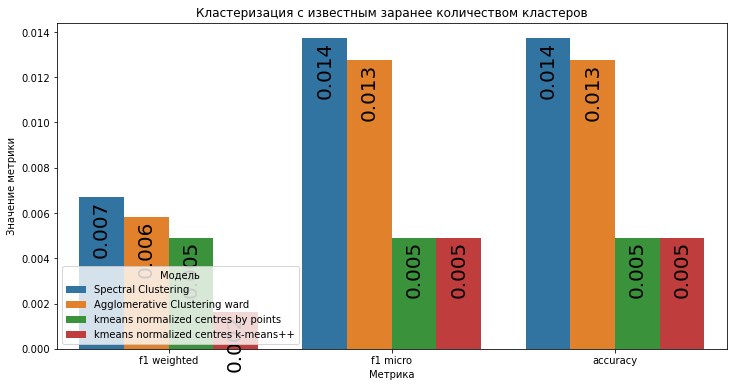

In [4]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x="Metric", y="Value",
                  hue="tags.mlflow.runName", data=clust_102_5_df)
sns.move_legend(bar, loc="upper left")
bar.set_xticklabels(["f1 weighted", "f1 micro", "accuracy"])
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение метрики")
plt.legend(title="Модель", loc="lower left")
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_title("Кластеризация с известным заранее количеством кластеров")
plt.show()

KMeans с указанием начальных точек кластеров как одна из точек, принадлежащих этому классу имеет качество выше, чем у алгоритма инициализации k-means++, но всё равно очень низким

Как видно, построенные модели имеют ужасное качество кластеризации. С неизвестным количеством кластеров дела состоят также плохо, но число кластеров в этих моделях не совпадает с исходным числом классов в тренировочных данных, из-за чего использование f1 метрики невозможно. Взамен ей используется скорректированный индекс Rand для оценки качества моделей

## Модели с заранее неизвестным количеством кластеров

In [5]:
experiment_name = "clusterization without the number of classes, 102 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    "experiment_id"]
clust_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=["metrics.adjusted_rand_score"]
)
clust_102_5_df = clust_102_5_df.iloc[::-1][
    ["tags.mlflow.runName", "metrics.adjusted_rand_score"]
]
clust_102_5_df = pd.melt(
    clust_102_5_df,
    id_vars="tags.mlflow.runName",
    value_vars=["metrics.adjusted_rand_score"],
    var_name="Metric",
    value_name="Value",
)

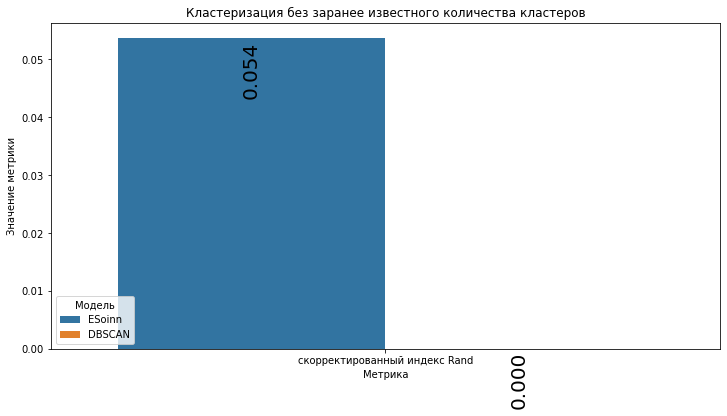

In [6]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x="Metric", y="Value",
                  hue="tags.mlflow.runName", data=clust_102_5_df)
sns.move_legend(bar, loc="upper left")
bar.set_xticklabels(["скорректированный индекс Rand"])
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение метрики")
plt.legend(title="Модель", loc="lower left")
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_title("Кластеризация без заранее известного количества кластеров")
plt.show()

DBScan вообще не может выделить кластеры, а ESoinn хоть и выделяет чуть больше, чем 102 кластера, но они не соответствуют исходным меткам в датасете

# Следующий подход: обучение с учителем, классификация голосов

Всего я использовал 4 разных набора данных: 
- по количеству классов
    - 102
    - 354
- по извлекаемым из аудио признакам
    - мел-кепстральные коэффициенты (метод описан ранее)
    - хромограмма, мел-спектрограмма, мел-кепстральные коэффициенты, тональные центры тяжести (методы не описаны в работе)

# Сначала рассмотрю модели, обученные только на мел-кепстральныx коэффициентах

# Классификация на 102 класса

В задачи классификации были выдвинуты те же ограничения, а именно 5 объектов каждого класса на обучающей выборке.

Было проверено большое количество моделей, параметры которых подбирались как с помощью поиска по сетке, так и с помощью библиотеки optuna для более тяжеловесных моделей

In [7]:
experiment_name = "only mfcc 102 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    "experiment_id"]
cls_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=["metrics.f1_weighted"])
cls_102_5_df = cls_102_5_df.iloc[::-1][
    [
        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
    ]
]
cls_102_5_df = pd.melt(
    cls_102_5_df,
    id_vars="tags.mlflow.runName",
    value_vars=["metrics.f1_weighted", "metrics.f1_micro", "metrics.accuracy"],
    var_name="Metric",
    value_name="Value",
)

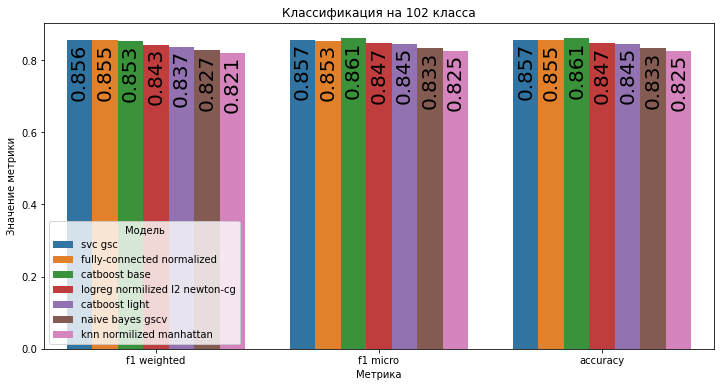

In [8]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x="Metric", y="Value",
                  hue="tags.mlflow.runName", data=cls_102_5_df)
sns.move_legend(bar, loc="upper left")
bar.set_xticklabels(["f1 weighted", "f1 micro", "accuracy"])
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение метрики")
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
plt.legend(title="Модель", loc="lower left")
bar.set_title("Классификация на 102 класса")
plt.show()

### Как видно из представленных выше графиков, лучше всего себя показывают метод опорных векторов, полносвязная нейронная сеть и градиентный бустинг. 
### Сравню эти модели по времени обучения

In [9]:
cls_102_5_df = mlflow.search_runs([experiment_id], order_by=["metrics.f1_weighted"])


best_models = cls_102_5_df[
    cls_102_5_df["tags.mlflow.runName"].isin(
        ["catboost base", "fully-connected normalized", "svc gsc"]
    )
]


best_models["training_time"] = (
    best_models["end_time"] - best_models["start_time"]
).dt.seconds


best_models = best_models[
    [

        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
        "training_time",
    ]
]

C:\Users\Никита\AppData\Local\Temp\ipykernel_16640\4081326634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['training_time'] = (


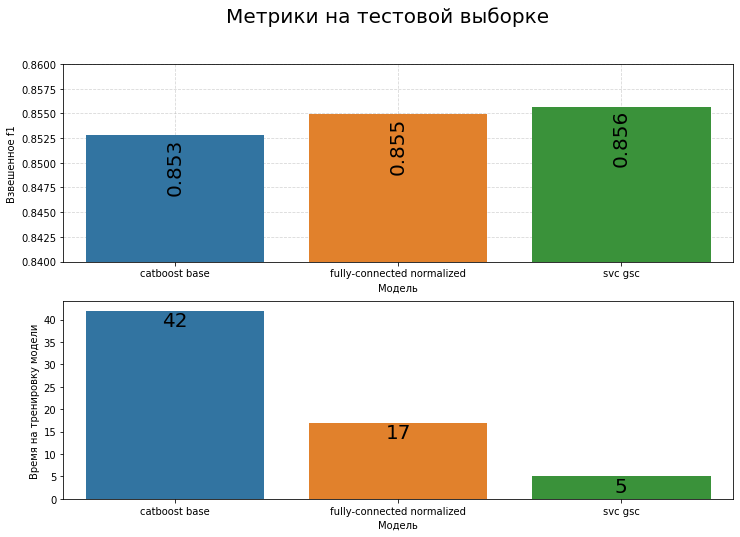

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.84, 0.86)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]), y="training_time", data=best_models
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Наглядно видно, что метод опорных векторов показывает себя лучше всего, начиная от качества, заканчивая временем, требуемым для обучения модели.

In [11]:
with open("cross_validation_scores/svc gsc.json", "r") as f:
    cv_scores = json.load(f)

svc_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])

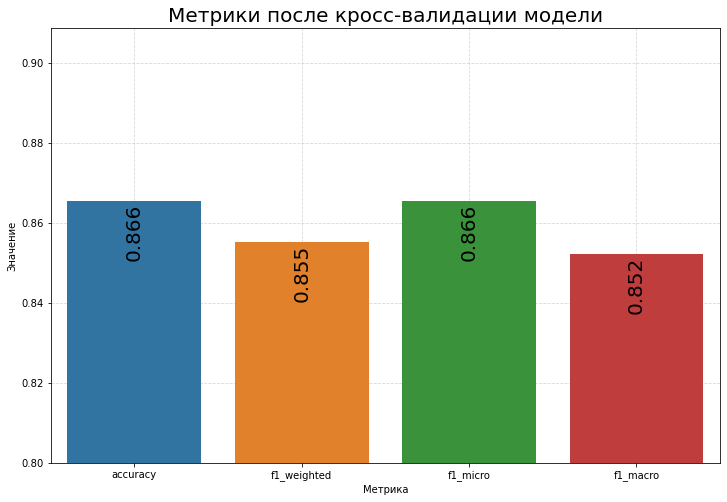

In [12]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=svc_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.8)
plt.show()

Значение метрик на кросс-валидации остались теми же, что говорит об отсутствии переобучения, путём подбора гиперпараметров

# Классификация на 354 класса

Увеличив количество классов, оставив при этом количество данных на класс равным пяти, предсказательные возможности модели, конечно же, станут ниже

In [13]:
experiment_name = "only mfcc 354 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    "experiment_id"]
cls_354_5_df = mlflow.search_runs(
    [experiment_id], order_by=["metrics.f1_weighted"])
cls_354_5_df = cls_354_5_df.iloc[::-1][
    [
        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
    ]
]
cls_354_5_df = pd.melt(
    cls_354_5_df,
    id_vars="tags.mlflow.runName",
    value_vars=["metrics.f1_weighted", "metrics.f1_micro", "metrics.accuracy"],
    var_name="Metric",
    value_name="Value",
)

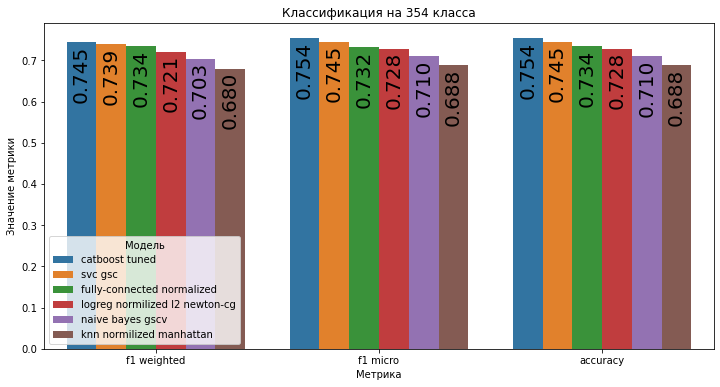

In [14]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x="Metric", y="Value",
                  hue="tags.mlflow.runName", data=cls_354_5_df)
sns.move_legend(bar, loc="upper left")
bar.set_xticklabels(["f1 weighted", "f1 micro", "accuracy"])
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение метрики")
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
plt.legend(title="Модель", loc="lower left")
bar.set_title("Классификация на 354 класса")
plt.show()

Сравню время, требуемое для обучения лучших моделей

In [15]:
cls_354_5_df = mlflow.search_runs([experiment_id], order_by=["metrics.f1_weighted"])


best_models = cls_354_5_df[
    cls_354_5_df["tags.mlflow.runName"].isin(
        ["catboost tuned", "svc gsc", "fully-connected normalized"]
    )
]


best_models["training_time"] = (
    best_models["end_time"] - best_models["start_time"]
).dt.seconds


best_models = best_models[
    [

        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
        "training_time",
    ]
]

C:\Users\Никита\AppData\Local\Temp\ipykernel_16640\1378941294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['training_time'] = (


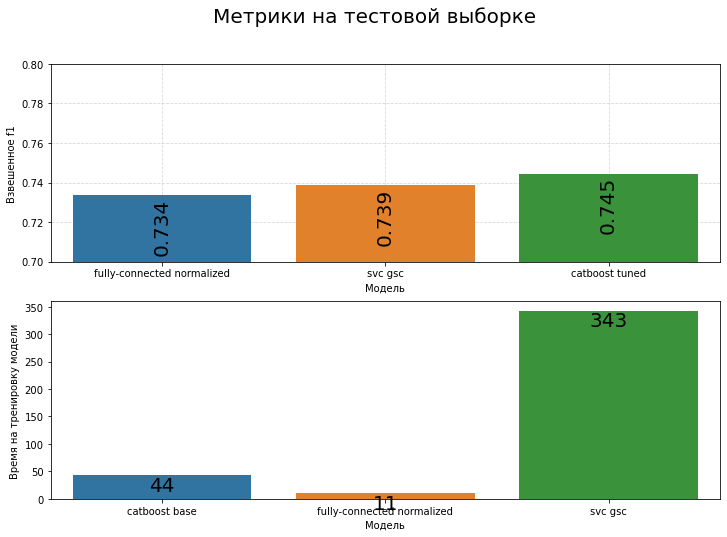

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7, 0.8)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=["catboost base", "fully-connected normalized", "svc gsc"],
    y="training_time",
    data=best_models,
)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Самой оптимальной моделью снова становится метод опорных векторов

In [17]:
with open("cross_validation_scores/svc gsc_354.json", "r") as f:
    cv_scores = json.load(f)

svc_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])

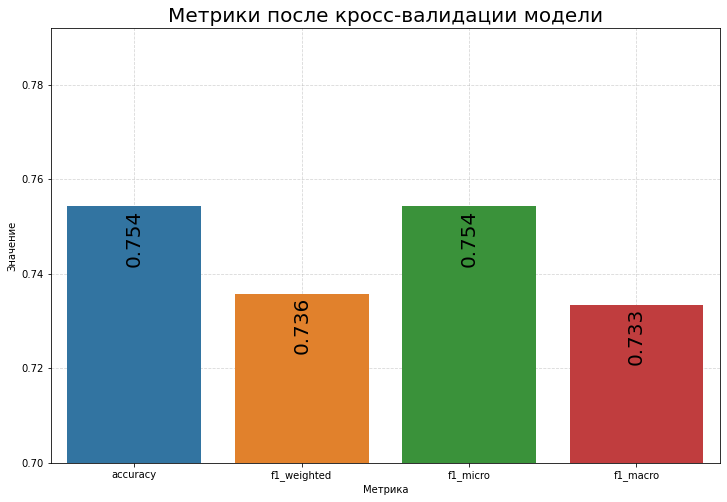

In [18]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=svc_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()

Метрики кросс-валидации выше, чем метрики на тесте. Значит, что при валидации модели во время подбора параметров была случайно выбрана более "сложная" для модели выборка.

В целом, можно сказать, что при увеличении количества классов, требуется увеличивать и количество аудиофайлов от каждого пользователя, но даже не делая этого, можно достичь хорошего результата. Проверю гипотезу об увеличении качества, при увеличении количества объектов каждого класса

In [19]:
with open("cross_validation_scores/svc gsc_354_more_data.json", "r") as f:
    cv_scores = json.load(f)

svc_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])

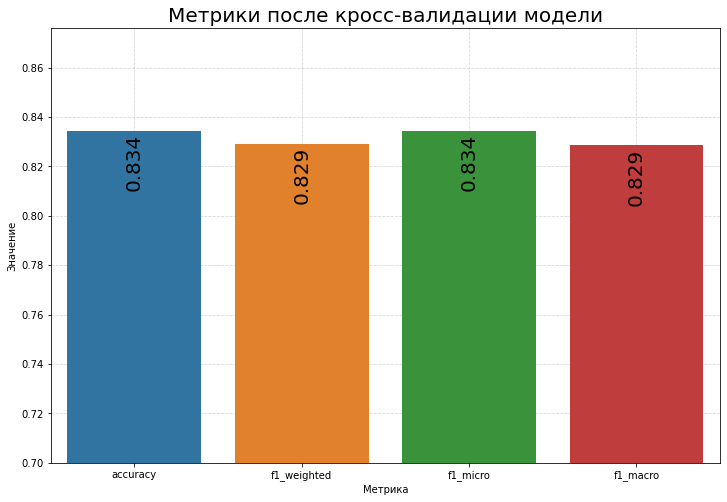

In [20]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=svc_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()

Как видно из графиков, метрики значительно выросли при увеличении количества объектов, принадлежащих к классу (количество объектов было увеличено в 2 раза, с пяти объектов на класс, до десяти)

# Модели, обученные на более широком множестве признаков

В предыдущем пункте для классификации использовались только мел-кепстральные коэффициенты. Сейчас я буду также использовать:
- хромограмму
- мел-спектрограмму
- тональные центры тяжести

## 102 класса

In [21]:
experiment_name = "102 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    "experiment_id"]
cls_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=["metrics.f1_weighted"])
cls_102_5_df = cls_102_5_df.iloc[::-1][
    [
        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
    ]
]

cls_102_5_df = cls_102_5_df.sort_values(by="metrics.f1_weighted", ascending=False).iloc[
    :10, :
]
best_models_names = cls_102_5_df["tags.mlflow.runName"]

cls_102_5_df = pd.melt(
    cls_102_5_df,
    id_vars="tags.mlflow.runName",
    value_vars=["metrics.f1_weighted", "metrics.f1_micro", "metrics.accuracy"],
    var_name="Metric",
    value_name="Value",
)

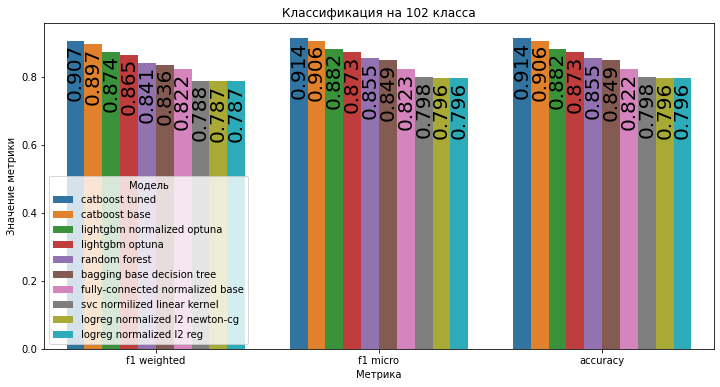

In [22]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x="Metric", y="Value",
                  hue="tags.mlflow.runName", data=cls_102_5_df)
sns.move_legend(bar, loc="upper left")
bar.set_xticklabels(["f1 weighted", "f1 micro", "accuracy"])
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение метрики")
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
plt.legend(title="Модель", loc="lower left")
bar.set_title("Классификация на 102 класса")
plt.show()

Как видно, преимуществами большого количества признаков смогли воспользоваться только древовидные модели. Посмотрю время, требуемое для обучения той или иной модели и выберу лучшую для проведения кросс-валидации.

In [23]:
cls_102_5_df = mlflow.search_runs([experiment_id], order_by=["metrics.f1_weighted"])


best_models = cls_102_5_df[cls_102_5_df["tags.mlflow.runName"].isin(best_models_names)]


best_models["training_time"] = (
    best_models["end_time"] - best_models["start_time"]
).dt.seconds
best_models = best_models[
    [

        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",

        "metrics.accuracy",
        "training_time",
    ]
]


best_models = best_models.sort_values(by="metrics.f1_weighted", ascending=False)

C:\Users\Никита\AppData\Local\Temp\ipykernel_16640\2555358958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['training_time'] = (


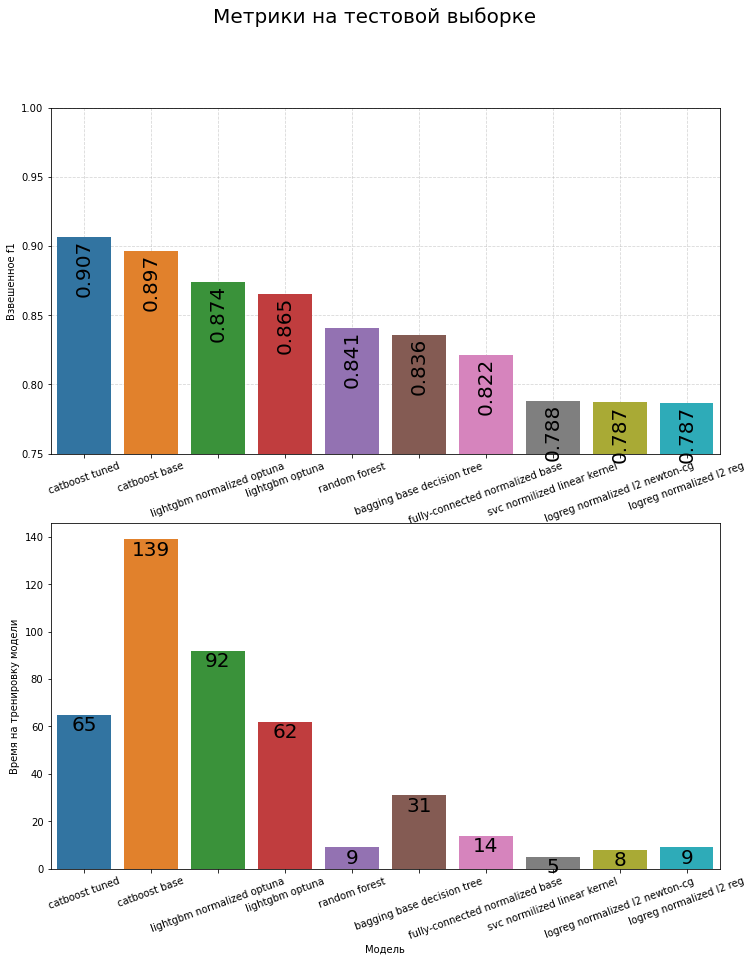

In [24]:
plt.figure(figsize=(12, 14))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.75, 1)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="training_time",
    data=best_models,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Таким образом, catboost с подобранными гиперпараметрами показывает лучшее качество

In [25]:
with open("cross_validation_scores/catboost tuned_102.json", "r") as f:
    cv_scores = json.load(f)

cb_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])

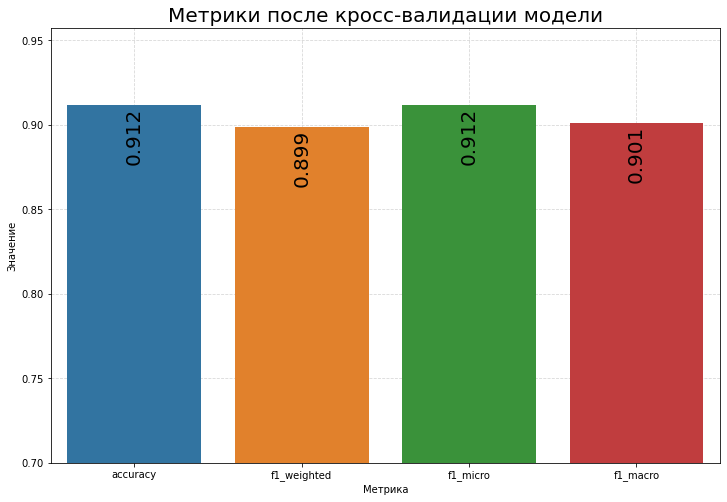

In [26]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=cb_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()

Значения метрик на кросс-валидации остались теми же, что говорит об отсутствии переобучения, путём подбора гиперпараметров под тестовые данные

## 354 класса

In [27]:
experiment_name = "354 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
    "experiment_id"]
cls_354_5_df = mlflow.search_runs(
    [experiment_id], order_by=["metrics.f1_weighted"])
cls_354_5_df = cls_354_5_df.iloc[::-1][
    [
        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
    ]
]

cls_354_5_df = cls_354_5_df.sort_values(by="metrics.f1_weighted", ascending=False).iloc[
    :10, :
]
best_models_names = cls_354_5_df["tags.mlflow.runName"]

cls_354_5_df = pd.melt(
    cls_354_5_df,
    id_vars="tags.mlflow.runName",
    value_vars=["metrics.f1_weighted", "metrics.f1_micro", "metrics.accuracy"],
    var_name="Metric",
    value_name="Value",
)

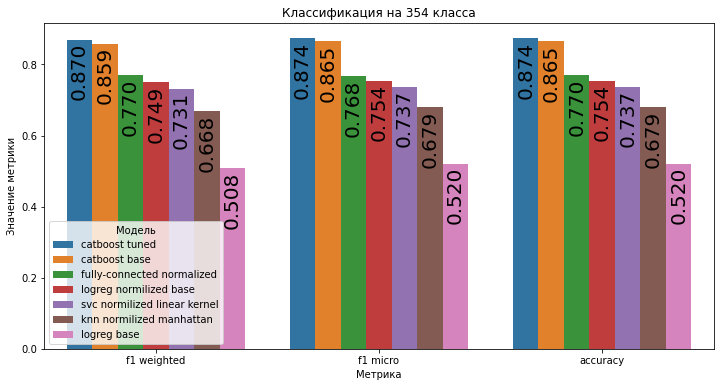

In [28]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x="Metric", y="Value",
                  hue="tags.mlflow.runName", data=cls_354_5_df)
sns.move_legend(bar, loc="upper left")
bar.set_xticklabels(["f1 weighted", "f1 micro", "accuracy"])
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение метрики")
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
plt.legend(title="Модель", loc="lower left")
bar.set_title("Классификация на 354 класса")
plt.show()

Здесь также лидирует catboost, причём со значительным отрывом от других моделей.

In [29]:
cls_354_5_df = mlflow.search_runs([experiment_id], order_by=["metrics.f1_weighted"])


best_models = cls_354_5_df[cls_354_5_df["tags.mlflow.runName"].isin(best_models_names)]


best_models["training_time"] = (
    best_models["end_time"] - best_models["start_time"]
).dt.seconds
best_models = best_models[
    [

        "tags.mlflow.runName",
        "metrics.f1_weighted",
        "metrics.f1_micro",
        "metrics.accuracy",
        "training_time",
    ]
]


best_models = best_models.sort_values(by="metrics.f1_weighted", ascending=False)

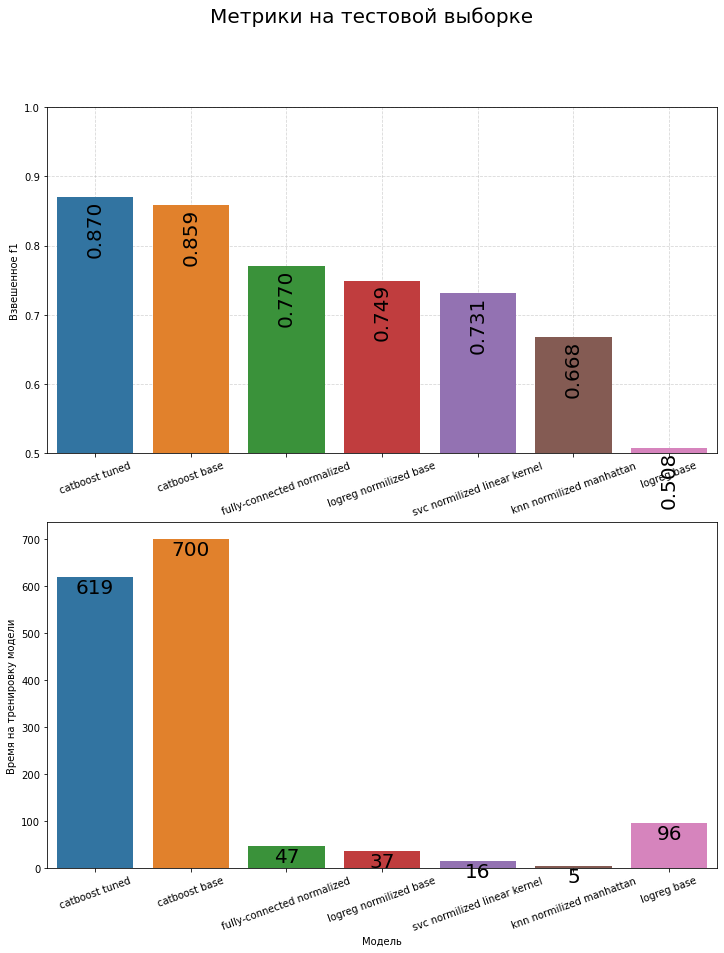

In [30]:
plt.figure(figsize=(12, 14))
plt.subplot(2, 1, 1)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="metrics.f1_weighted",
    data=best_models,
    zorder=2,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Модель")
bar.set_ylabel("Взвешенноe f1")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.5, 1)

plt.subplot(2, 1, 2)
bar = sns.barplot(
    x=list(best_models["tags.mlflow.runName"]),
    y="training_time",
    data=best_models,
)
plt.xticks(rotation=20)
for container in bar.containers:
    bar.bar_label(container, fmt="%.0f", size=20, padding=-20)
bar.set_xlabel("Модель")
bar.set_ylabel("Время на тренировку модели")

plt.suptitle("Метрики на тестовой выборке", size=20)
plt.show()

Как видно, время на обучение градиентного бустинга значительно превышает время обучения других алгоритмов. Несмотря на это, прирост в качестве также значителен, из-за чего остановлю свой выбор именно на этой модели

In [31]:
with open("cross_validation_scores/catboost tuned_354.json", "r") as f:
    cv_scores = json.load(f)

cb_res = pd.DataFrame(list(cv_scores.items()), columns=["Metric", "Score"])

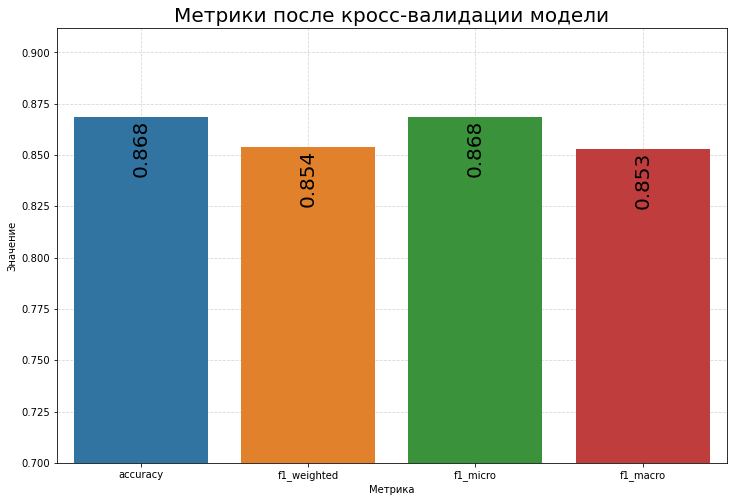

In [32]:
plt.figure(figsize=(12, 8))
plt.title("Метрики после кросс-валидации модели", size=20)
bar = sns.barplot(x="Metric", y="Score", data=cb_res, zorder=2)
for container in bar.containers:
    bar.bar_label(container, fmt="%.3f", rotation=90, padding=-60, size=20)
bar.set_xlabel("Метрика")
bar.set_ylabel("Значение")
plt.grid(alpha=0.5, linestyle="--", zorder=0)
plt.ylim(0.7)
plt.show()

Целевая метрика при подсчёте её с помощью кросс-валидации немного уменьшилась, но не настолько, чтобы выбрать другую модель.

### По итогам моего исследования лучшими моделями оказались:

Для 102 классов
- модель на методе опорных векторов, использующая мел-кепстральные коэффициенты 

Для 354 классов
- модель градиентного бустинга, использующая все основные численные значения, описывающие аудиосигнал

# Следующим этапом исследования является применение данных моделей для проверки наличия человека в обучающей выборке

# Первый подход: определение разделяющего вероятностного порога

In [ ]:
df = pd.read_pickle("experiments/crowd_train_all_data_embedded.pkl")

In [ ]:
df_t = get_dataframe(df, 200, 10)
not_in_df_t = get_dataframe(df, 0, 3, max_filter=10)

df_t.shape[0], not_in_df_t.shape[0]


102
316


(1020, 907)

In [ ]:
X = np.vstack(df_t.audio_feature.to_numpy()).reshape(df_t.shape[0], -1)
le = LabelEncoder()
y = le.fit_transform(df_t.source_id)
X_mfccs = X[:, 36 + 384 : 36 + 384 + 60]  # mfcc only

X.shape, X_mfccs.shape, y.shape

((1020, 498), (1020, 60), (1020,))

In [ ]:
X_not = np.vstack(not_in_df_t.audio_feature.to_numpy()).reshape(
    not_in_df_t.shape[0], -1
)
le_not = LabelEncoder()
y_not = le.fit_transform(not_in_df_t.source_id)
X_mfccs_not = X_not[:, 36 + 384 : 36 + 384 + 60]  # mfcc only

X_not.shape, X_mfccs_not.shape, y_not.shape

((907, 498), (907, 60), (907,))

In [ ]:
def get_model_and_params(
    experiment_name: str, model_name: str, model_type: str = 'sklearn'
):
    experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))[
        'experiment_id'
    ]

    cls_102_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
    svc_df = cls_102_5_df[cls_102_5_df['tags.mlflow.runName'] == model_name]
    model_dict = dict(
        eval(svc_df['tags.mlflow.log-model.history'].item().replace('null', 'None'))[0]
    )
    logged_model = '/'.join(
        ['runs:', model_dict['run_id'], model_dict['artifact_path']]
    )

    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    loaded_model = eval(f'mlflow.{model_type}.load_model(logged_model)')

    params = (
        svc_df[svc_df.columns[svc_df.columns.str.startswith('params.')]]
        .dropna(axis=1)
        .to_dict()
    )
    params = {k.split('.')[-1]: list(v.values())[-1] for k, v in params.items()}
    for k, v in params.items():
        if v.isdigit():
            v = int(v)
        elif v.replace('.', '').isdigit():
            v = float(v)
        params[k] = v

    return loaded_model, params

# SVM, 102 класса, mfcc фичи

In [ ]:
experiment = "only mfcc 102 classes"
model_name = "svc gsc"
loaded_model, params = get_model_and_params(experiment, model_name)


2024/05/10 16:03:53 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_mfccs, y, test_size=0.5, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
preds_val = loaded_model.predict(X_val_scaled)
metrics.f1_score(y_val, preds_val, average="weighted")


0.8556857086268851

Модели, построенные методом опорных опорных векторов, не являются вероятностными, а следовательно требуют какого-либо классификатора на своих выходах, чтобы получить вероятности на основе их предсказаний (которые являются расстояниями до наиближайших опорных векторов). 

При использовании параметра probability = True используется логистическая регрессия для получения вероятностей, которая не очень хорошо справляется с этой задачей (например, не выполняется y_pred == argmax(probabilities)). 

Decision_function также не подошла под мои нужны, потому что различия между расстоянии до разделяющих векторов очень малы и подобрать какой-то адекватный порог на них не представляется возможным. 

По этой причине я использую класс CalibratedClassifierCV для получения вероятностей, который использует изотоническую регрессию и кросс-валидацию при обучении, что обеспечивает наилучший результата. Как показано ниже, метрика на валидации упала на 0.001, что не критично

In [ ]:
params = {"kernel": "rbf", "decision_function_shape": "ovr", "C": 5}
model = SVC(**params)
calibrated = CalibratedClassifierCV(model, method="isotonic", cv=5)
calibrated.fit(X_train_scaled, y_train)
calibrated_probs = calibrated.predict_proba(X_val_scaled)


In [ ]:
# f1 мера для svm и изометрической регрессии
preds_val = calibrated.predict(X_val_scaled)
metrics.f1_score(y_val, preds_val, average="weighted")


0.854234599822835

In [ ]:
# вероятность, когда модель правильно классифицировала
true_probs = np.max(calibrated_probs, axis=1)[preds_val == y_val]
true_probs.mean()


0.7432785292376581

In [ ]:
false_probs = np.max(calibrated_probs, axis=1)[preds_val != y_val]
false_probs.mean()


0.5586797794527484

In [ ]:
scaler_not = StandardScaler()
X_mfccs_not_scaled = scaler.fit_transform(X_mfccs_not)
calibrated_probs_not = calibrated.predict_proba(X_mfccs_not_scaled)
not_probs = np.max(calibrated_probs_not, axis=1)
not_probs.mean()


0.5849930826728947

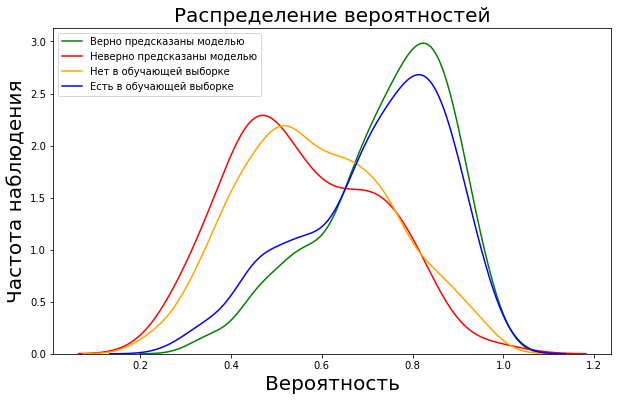

In [ ]:
all_probs = np.max(calibrated_probs, axis=1)
plt.figure(figsize=(10, 6))
plt.title("Распределение вероятностей", size=20)
sns.kdeplot(true_probs, color="green", label="Верно предсказаны моделью")
sns.kdeplot(false_probs, color="red", label="Неверно предсказаны моделью")
sns.kdeplot(not_probs, color="orange", label="Нет в обучающей выборке")
sns.kdeplot(all_probs, color="blue", label="Есть в обучающей выборке")

plt.ylabel("Частота наблюдения", size=20)
plt.xlabel("Вероятность", size=20)
plt.legend()


Визуально можно оценить, что наилучший разделяющий порог лежит примерно около 0.7

Для поиска наилучшего порога, используемого для разделения, воспользуюсь площадью под pr кривой. Для моей задачи более важна полнота, но также должна учитываться и точность, из-за чего я и использую f-меру, но не со стандартным значением beta=1, а с меньшим (0.8 было выбрано из эвристического понимания задачи, после визуализации выше)

In [ ]:
in_df = np.hstack(
    [
        np.stack([all_probs, np.ones(all_probs.shape)]),
        np.stack([not_probs, np.zeros(not_probs.shape)]),
    ]
)

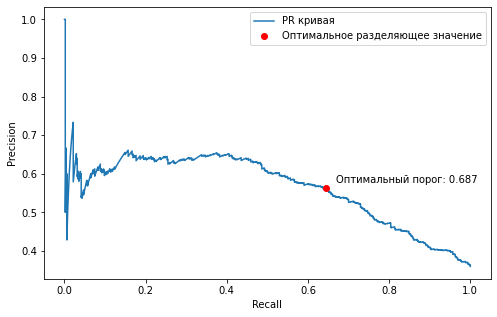

In [ ]:
precision, recall, thresholds = precision_recall_curve(in_df[1, :], in_df[0, :])
beta = 0.8
f1_scores = (1 + beta**2) * recall * precision / (recall + beta**2 * precision)

idx_max_f1 = np.argmax(f1_scores)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='PR кривая')
plt.scatter(
    recall[idx_max_f1],
    precision[idx_max_f1],
    color='red',
    label='Оптимальное разделяющее значениe',
    zorder=3,
)
plt.annotate(
    f'Оптимальный порог: {round(thresholds[idx_max_f1], 3)}',
    (recall[idx_max_f1], precision[idx_max_f1]),
    textcoords='offset points',
    xytext=(10, 5),
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
# точность в каждой группе после разделения по пороговому значению
true_trsh = in_df[1, :][in_df[0, :] > thresholds[idx_max_f1]]
false_trsh = in_df[1, :][in_df[0, :] < thresholds[idx_max_f1]]

sum(true_trsh) / len(true_trsh), (len(false_trsh) - sum(false_trsh)) / len(false_trsh)

(0.5616438356164384, 0.7824519230769231)

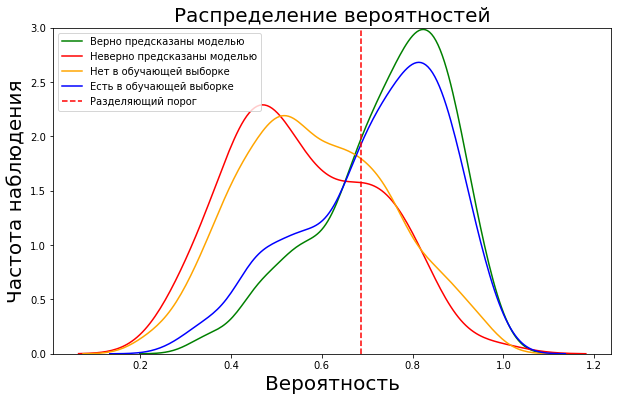

In [ ]:
all_probs = np.max(calibrated_probs, axis=1)
plt.figure(figsize=(10, 6))
plt.title("Распределение вероятностей", size=20)
sns.kdeplot(true_probs, color="green", label="Верно предсказаны моделью")
sns.kdeplot(false_probs, color="red", label="Неверно предсказаны моделью")
sns.kdeplot(not_probs, color="orange", label="Нет в обучающей выборке")
sns.kdeplot(all_probs, color="blue", label="Есть в обучающей выборке")
plt.vlines(
    round(thresholds[idx_max_f1], 3),
    ymin=0,
    ymax=3,
    color="red",
    label="Разделяющий порог",
    linestyle="--",
)

plt.ylabel("Частота наблюдения", size=20)
plt.xlabel("Вероятность", size=20)
plt.ylim(0, 3)
plt.legend()
plt.show()

Функция для поиска оптимального порога

In [ ]:
def get_pr_threshold(all_probs, not_probs, beta=0.25, plot=False):
    in_df = np.hstack(
        [
            np.stack([all_probs, np.ones(all_probs.shape)]),
            np.stack([not_probs, np.zeros(not_probs.shape)]),
        ]
    )

    precision, recall, thresholds = precision_recall_curve(in_df[1, :], in_df[0, :])
    f1_scores = (1 + beta**2) * recall * precision / (recall + beta**2 * precision)

    idx_max_f1 = np.argmax(f1_scores)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(recall, precision, label='PR кривая')
        plt.scatter(
            recall[idx_max_f1],
            precision[idx_max_f1],
            color='red',
            label='Оптимальное разделяющее значениe',
            zorder=3,
        )
        plt.annotate(
            f'Оптимальный порог: {round(thresholds[idx_max_f1], 3)}',
            (recall[idx_max_f1], precision[idx_max_f1]),
            textcoords='offset points',
            xytext=(10, 5),
        )
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

    return thresholds[idx_max_f1], in_df

In [ ]:
with open(f"cross_validation_scores/{model_name}_threshold.json", "w") as f:
    json.dump({"threshold": thresholds[idx_max_f1]}, f)


# catboost, 354 класса, все фичи

Предобработка данных

In [ ]:
df_t = get_dataframe(df, 100, 10)
not_in_df_t = get_dataframe(df, 0, 13, max_filter=18)

X = np.vstack(df_t.audio_feature.to_numpy()).reshape(df_t.shape[0], -1)
le = LabelEncoder()
y = le.fit_transform(df_t.source_id)

X_not = np.vstack(not_in_df_t.audio_feature.to_numpy()).reshape(
    not_in_df_t.shape[0], -1
)
le_not = LabelEncoder()
y_not = le.fit_transform(not_in_df_t.source_id)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)


354
408


загрузка модели

In [ ]:
experiment = "354 classes, 5 per class"
model_name = "catboost tuned"
loaded_model, params = get_model_and_params(
    experiment, model_name, model_type="catboost"
)

In [ ]:
preds_val = loaded_model.predict(X_val)
metrics.f1_score(y_val, preds_val, average="weighted")


0.8702095142773109

In [ ]:
cb_probs = loaded_model.predict_proba(X_val)

In [ ]:
# вероятность, когда модель правильно классифицировала
true_probs = np.max(cb_probs, axis=1)[
    np.array([preds_val == y_val.reshape(-1, 1)]).flatten()
]

false_probs = np.max(cb_probs, axis=1)[
    np.array([preds_val != y_val.reshape(-1, 1)]).flatten()
]

predict_proba_not = loaded_model.predict_proba(X_not)
not_probs = np.max(predict_proba_not, axis=1)

all_probs = np.max(cb_probs, axis=1)

true_probs.mean(), false_probs.mean(), not_probs.mean(), all_probs.mean()

(0.4776358659662475,
 0.15268437161150378,
 0.12575967079519426,
 0.4366956494458476)

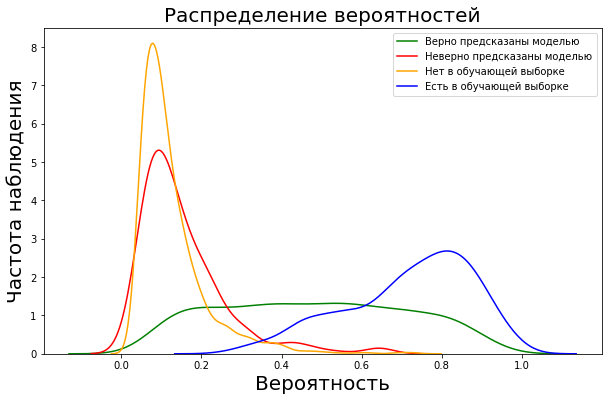

In [ ]:
all_probs = np.max(calibrated_probs, axis=1)
plt.figure(figsize=(10, 6))
plt.title("Распределение вероятностей", size=20)
sns.kdeplot(true_probs, color="green", label="Верно предсказаны моделью")
sns.kdeplot(false_probs, color="red", label="Неверно предсказаны моделью")
sns.kdeplot(not_probs, color="orange", label="Нет в обучающей выборке")
sns.kdeplot(all_probs, color="blue", label="Есть в обучающей выборке")

plt.ylabel("Частота наблюдения", size=20)
plt.xlabel("Вероятность", size=20)
plt.legend()


Как видно из графика, классы принадлежности к выборке намного легче разделимы к catboost'а по сравнению с SVM моделью. Порог лежит примерно около 0.2 - 0.3. Найду его также с помощью pr кривой. Коэффициент beta > 1, что говорил о смещении в сторону точности. Мой выбор связан с тем, что вероятности принадлежности к верному классу распределены довольно равномерно, из-за чего поставив высокий порог и получив отличный recall, я получу низкий precision, в то время как исходя из визуализации лучший порог находится примерно около 0.25, а не у 0.7, который максимизирует recall.

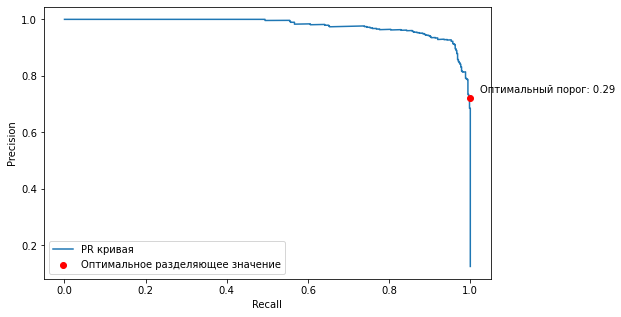

0.2896592301118485

In [ ]:
threshold, in_df = get_pr_threshold(all_probs, not_probs, beta=6, plot=True)
threshold


In [ ]:
# точность в каждой группе после разделения по пороговому значению
true_trsh = in_df[1, :][in_df[0, :] > threshold]
false_trsh = in_df[1, :][in_df[0, :] < threshold]

sum(true_trsh) / len(true_trsh), (len(false_trsh) - sum(false_trsh)) / len(false_trsh)

(0.7226173541963016, 0.9997021149836163)

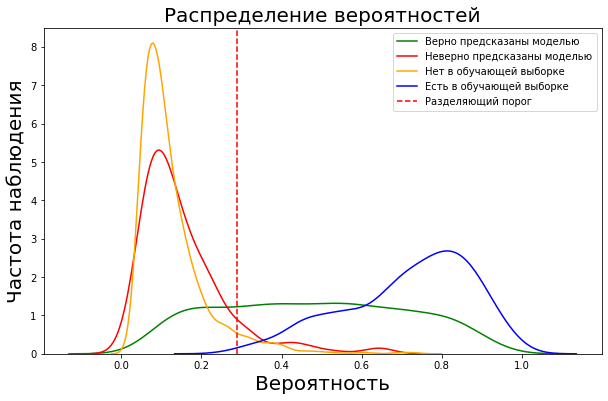

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Распределение вероятностей", size=20)
sns.kdeplot(true_probs, color="green", label="Верно предсказаны моделью")
sns.kdeplot(false_probs, color="red", label="Неверно предсказаны моделью")
sns.kdeplot(not_probs, color="orange", label="Нет в обучающей выборке")
sns.kdeplot(all_probs, color="blue", label="Есть в обучающей выборке")
plt.vlines(
    round(threshold, 3),
    ymin=0,
    ymax=8.5,
    color="red",
    label="Разделяющий порог",
    linestyle="--",
)

plt.ylabel("Частота наблюдения", size=20)
plt.xlabel("Вероятность", size=20)
plt.ylim(0, 8.5)
plt.legend()
plt.show()

In [ ]:
with open(f"cross_validation_scores/{model_name}_threshold.json", "w") as f:
    json.dump({"threshold": threshold}, f)


Сравнивая две рассмотренные модели, закономерности, выявленные catboost'ом работают лучше, ведь его графики распредления представленных и не представленных в датасета классов хорошо разделимы, в отличии от svm модели, где они пересекаются намного сильнее

Исходя из этого, итоговой моделью, для которой я построю графический интерфейс для взаимодействия, будет именно catboost на 354 класса, обученный на всех признаках, полученных из аудиодорожки.

# Нахождение порога с помощью tpr@fpr метрики

### Метрика TPR@FPR

Для того, чтобы измерить принадлежность векторов к имеющемуся домену голосов, можно использовать следующую метрику. Обычно она используется для моделей, которые обучаются создавать векторные представления чего-либо, но в моём случае, её можно использовать на выходах из алгоритма получения мел-кепстральных коэффициентов. Я буду использовать только их, в то время как классификатор обучен на более широком наборе признаков, так как они лучше всего отражают специфику аудио сигнала.

### Алгоритм реализации метрики

Необходимо создать два набора векторных представлений аудио: query и distractors. 
Никакие аудио из этих наборов не должны содержаться в обучающем и валидационном датасете.

In [ ]:
df = pd.read_pickle("experiments/crowd_train_all_data_embedded.pkl")

In [ ]:
query = get_dataframe(df, 0, 13, max_filter=18)
query.shape[0]


408


3551

In [ ]:
distractors = get_dataframe(df, 20, 18, max_filter=30)
distractors.shape[0]


196


3528

Посчитаю косинусные расстояния между векторами, которые соответствуют одним и тем же людям из query части.

In [ ]:
between_one_class_in_query = []
for s_id in tqdm(set(query.source_id)):
    temp_arr = query[query.source_id == s_id].audio_feature.to_numpy()
    for i in range(len(temp_arr)):
        for j in range(i + 1, len(temp_arr)):
            between_one_class_in_query.append(
                cosine(
                    temp_arr[i][36 + 384 : 36 + 384 + 60],
                    temp_arr[j][36 + 384 : 36 + 384 + 60],
                )
            )

  0%|          | 0/408 [00:00<?, ?it/s]

Посчитаю косинусные расстояния между векторами, которые соответствуют разным людям из query части.

In [ ]:
between_diff_class_in_query = []
visited = []

for s_id in tqdm(set(query.source_id)):
    visited.append(s_id)
    temp_arr_selected_class = query[query.source_id == s_id].audio_feature.to_numpy()
    temp_arr_other_class = query[
        ~query.source_id.isin(visited)
    ].audio_feature.to_numpy()

    for selected_emb in temp_arr_selected_class:
        for other_emb in temp_arr_other_class:
            between_diff_class_in_query.append(
                cosine(
                    selected_emb[36 + 384 : 36 + 384 + 60],
                    other_emb[36 + 384 : 36 + 384 + 60],
                )
            )

  0%|          | 0/408 [00:00<?, ?it/s]

Посчитаю косинусные расстояния между всеми парами из query и distractors. Всего получится |query|*|distractors| пар.

In [ ]:
between_query_distractors = []

for i in tqdm(query.audio_feature.to_numpy()):
    for j in distractors.audio_feature.to_numpy():
        between_query_distractors.append(
            cosine(i[36 + 384 : 36 + 384 + 60], j[36 + 384 : 36 + 384 + 60])
        )

  0%|          | 0/3551 [00:00<?, ?it/s]

Сложу количество пар, которые были получены на 2 и 3 шагах. Это будет количеством false пар.

In [ ]:
false_pairs = copy(between_diff_class_in_query)

In [ ]:
false_pairs.extend(between_query_distractors)

Зафиксирую допустимый FPR (false positive rate). Пусть он, например, будет равен 0.01. FPR, умноженный на количество false пар из шага 4 - это разрешенное количество false positives, которые я разрешаю модели. Обозначу это количество через N.

In [ ]:
FPR = 0.01
N = round(FPR * len(false_pairs))
N


188150

Отсортирую все значения косинусных расстояний false пар. N - ое по счету значение расстояния зафиксирую как пороговое расстояние.

In [ ]:
false_pairs.sort()

In [ ]:
threshold = false_pairs[N]
threshold


0.0048326071016201455

Посчитаю количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделю это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) - итоговое значение метрики.

In [ ]:
positive_pairs = np.array(between_one_class_in_query)

In [ ]:
len(positive_pairs[positive_pairs < threshold]) / len(positive_pairs)

0.4184032136580467

Нарисую визуализацию, чтобы подобрать устраивающий меня False Positive Rate

In [ ]:
FPRs = np.linspace(0, 1, 1_000)[:-1]
TPRs = []

for FPR in FPRs:
    N = round(FPR * len(false_pairs))
    threshold = false_pairs[N]
    TPRs.append(len(positive_pairs[positive_pairs < threshold]) / len(positive_pairs))

[]

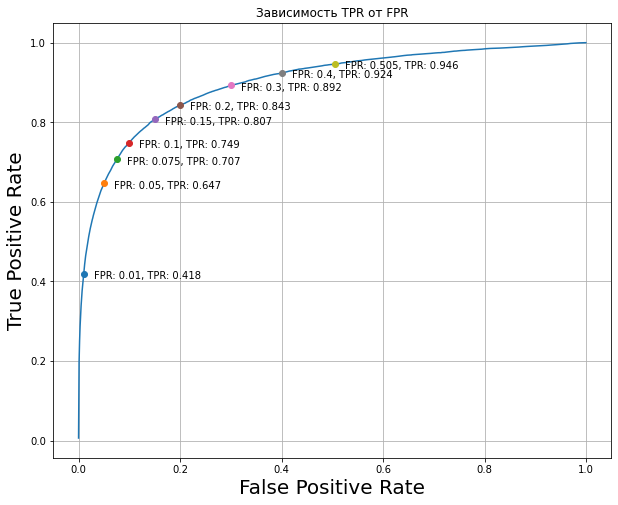

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Зависимость TPR от FPR")
plt.grid()
plt.plot(FPRs, TPRs)
for fprate in [0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.505]:
    indx = np.where(np.round(FPRs, 3) == fprate)[0].item()
    plt.scatter(FPRs[indx], TPRs[indx], zorder=3)
    plt.annotate(
        f"FPR: {round(FPRs[indx], 3)}, TPR: {round(TPRs[indx], 3)}",
        (FPRs[indx], TPRs[indx]),
        textcoords="offset points",
        xytext=(10, -5),
    )
plt.xlabel("False Positive Rate", size=20)
plt.ylabel("True Positive Rate", size=20)
plt.plot()

Подбор FPR зависит от уровня безопасности, которого необходимо достигнуть в идентификационной системе. Уменьшая FPR получаем более низкий порог, которой уменьшает как количество ложных срабатываний, так и количество верных срабатывания системы. Таким образом, оптимальным я считаю fpr = 0.075, так как он поддерживает адекватный уровень tpr.

In [ ]:
model_name = "catboost tuned"

with open(f"cross_validation_scores/{model_name}_threshold.json", "r") as f:
    d = json.load(f)

d


{'threshold': 0.2896592301118485}

In [ ]:
FPR = 0.075
N = round(FPR * len(false_pairs))
threshold = false_pairs[N]
threshold


0.008504369429957692

In [ ]:
d["tpr@fpr_threshold"] = threshold
d


{'threshold': 0.2896592301118485, 'tpr@fpr_threshold': 0.008504369429957692}

In [ ]:
with open(f"cross_validation_scores/{model_name}_threshold.json", "w") as f:
    json.dump(d, f)


# Заключительный этап: тестирование модели

Для этого я сделал простой инференс на gradio, который позволяет загрузить аудио файл через web интерфейс и получить предсказание модели. Также выводится информация о том, зарегистрирован ли пользователь в базе исходя из двух методов, описанных выше. Пример того, как выглядит итоговое решение:

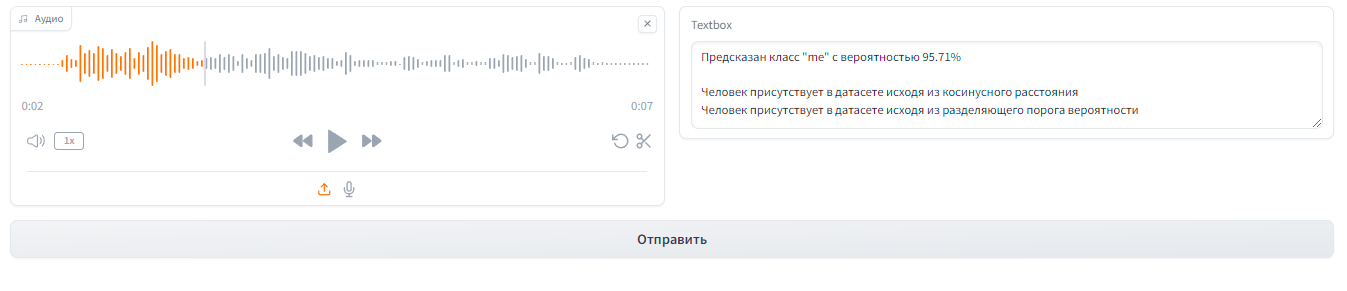

Перед использование модель была переобучена на данных, включающих мой голос.
<br>
Добавление голосов в датасет описано в файле:
> ***evaluation\get_evaluation.ipynb***

А больше примеров можно найти в 
> ***evaluation_screenshots\evaluation_screenshots.pdf***

Код для запуска модели с помощью gradio представлен далее

Для проверки модели произведу идентификацию по своему голосу. Для этого необходимо обучить модель на данных, включающих мой голос, а также применить фильтрацию по порогу, который определяет, есть тот или иной голос в рассматрвиаемой базе голосов.

Тестировать буду наилучшую модель, а именно catboost с подобранными параметрами

In [ ]:
df = pd.read_pickle("experiments/crowd_train_all_data_embedded.pkl")

In [ ]:
df_t = get_dataframe(df, 100, 10)
df_t.head()


354


,audio_path,source_id,audio_feature
0,crowd_train\wavs/cb9733d3521a52dd7a578503dc982...,02d58cb47f02f8884aaa45b0f7dd7714,"[0.36070194840431213, 0.36269721388816833, 0.3..."
1,crowd_train\wavs/40dddbe3d8c0bcb4fd8b3c933f660...,02d58cb47f02f8884aaa45b0f7dd7714,"[0.38155198097229004, 0.4070906341075897, 0.44..."
2,crowd_train\wavs/19a6f9ce1902ffb0f45c05f5e621e...,02d58cb47f02f8884aaa45b0f7dd7714,"[0.36854031682014465, 0.4035727083683014, 0.44..."
3,crowd_train\wavs/d9050a9ec2523b61435ad2a2b4aca...,02d58cb47f02f8884aaa45b0f7dd7714,"[0.33979716897010803, 0.35216024518013, 0.3810..."
4,crowd_train\wavs/a931c958489a78e12956ebee1e13a...,02d58cb47f02f8884aaa45b0f7dd7714,"[0.32755956053733826, 0.3753350079059601, 0.39..."


In [ ]:
df_me = pd.read_parquet("evaluation/eval_df.pqt")
df_me.head()


,audio_path,source_id,audio_feature
0,maria\Record_0.wav,maria,"[0.22580918669700623, 0.23982486128807068, 0.1..."
1,maria\Record_1.wav,maria,"[0.2748687267303467, 0.2674121558666229, 0.265..."
2,maria\Record_2.wav,maria,"[0.21786867082118988, 0.25627416372299194, 0.3..."
3,maria\Record_3.wav,maria,"[0.3032059073448181, 0.2491905242204666, 0.236..."
4,maria\Record_4.wav,maria,"[0.17937365174293518, 0.1685197949409485, 0.26..."


In [ ]:
eval_df = pd.concat([df_t, df_me]).reset_index(drop=True)

In [ ]:
X = np.vstack(eval_df.audio_feature.to_numpy()).reshape(eval_df.shape[0], -1)
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(eval_df.source_id))

X.shape, y.shape

((3560, 498), (3560, 1))

In [ ]:
le.transform(["me", "maria"])  # добавленные мной классы

array([355, 354])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

Мои записи голоса, которые не использовались для обучения (валидационная выборка)

In [ ]:
eval_df.iloc[
    list(set(eval_df[eval_df.source_id == "me"].index) & set(y_val.index))
].sort_index()

,audio_path,source_id,audio_feature
3551,me\Record_1.wav,me,"[0.3570057451725006, 0.391750305891037, 0.2994..."
3553,me\Record_3.wav,me,"[0.333279013633728, 0.3944181501865387, 0.3920..."
3555,me\Record_5.wav,me,"[0.32722488045692444, 0.40390798449516296, 0.2..."
3556,me\Record_6.wav,me,"[0.3516620993614197, 0.39537549018859863, 0.39..."
3559,me\Record_9.wav,me,"[0.4068811237812042, 0.4601544439792633, 0.555..."


Дообучение модели на + 2 новых классах

In [ ]:
already_exists = True

if not already_exists:
    pass
    # код, использовавшийся для обучения вынесен в get_evaluation.ipynb
    # из-за громоздкости
else:
    model_cb = catboost.CatBoostClassifier()
    model_cb.load_model("cb_model")
    model_name = "catboost tuned"

    with open(f"cross_validation_scores/{model_name}_threshold.json", "r") as f:
        d = json.load(f)

In [ ]:
def authorize(audio):
    features = get_feature(audio)
    probs = model_cb.predict_proba(features)
    pred_class = le.inverse_transform([np.argmax(probs)])[0]
    max_prob = np.max(probs)

    result = f'Предсказан класс "{pred_class}" с вероятностью {round(max_prob*100, 2)}%'

    c = 0
    train_part_df = eval_df.iloc[
        list(set(eval_df[eval_df.source_id ==
             pred_class].index) - set(y_val.index))
    ]
    for cos_dist_true in train_part_df.audio_feature:
        if cosine(cos_dist_true, features) <= d['tpr@fpr_threshold']:
            c += 1

    if c >= 3:
        result += '\n\nЧеловек присутствует в датасете исходя из косинусного расстояния'
    else:
        result += (
            '\n\nЧеловек НЕ присутствует в датасете исходя из косинусного расстояния'
        )
    if max_prob >= d['threshold']:
        result += '\nЧеловек присутствует в датасете исходя из разделяющего порога вероятности'
    else:
        result += '\nЧеловек НЕ присутствует в датасете исходя из разделяющего порога вероятности'

    return result


with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            audio = gr.Audio(sources=["upload", "microphone"], type="filepath")
        with gr.Column():
            textbox = gr.Textbox()

    button = gr.Button("Отправить")
    button.click(fn=authorize, inputs=[audio], outputs=[textbox])

demo.launch(debug=True)

# Выводы

Мною была успешна решена задача идентификации личности по голосу. Была построена модель машинного обучения, решающая поставленную задачу, которая затем была опробована на реальных данных

В ходе выполнения работы я понял, что:
- Мел-кепстральные коэффициенты являются лучшим способом векторизации аудиосигналов
- Для данной задачи очень проблематично применение методов кластеризации
- В условиях ограниченности количества данных и большом количестве различных классов лучше всего себя показывает градиентный бустинг, но такие классические алгоритмы, как метод опорных векторов также неплохо справляются
- Подбор порога для проверки принадлежности голоса обучающей выборке сильно зависит от необходимого уровня безопасности, ведь напрямую зависит от допустимого уровня false positive rate